# Querying The Loan Data

In [2]:
import pandas as pd
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
df_analyse = pd.read_csv(r'Source_Files\pretransformed_loan_payments.csv')

In [4]:
pdf_filename = 'query_viz.pdf'
pdf = PdfPages(pdf_filename)

## Current State Of Loans

In [5]:
df_analyse['total_amount_due'] = df_analyse['instalment'] * df_analyse['term (months)']

In [6]:
alt_paid = 100 * (df_analyse['total_payment'].sum() / df_analyse['total_amount_due'].sum())
alt_paid.round(2)

np.float64(70.68)

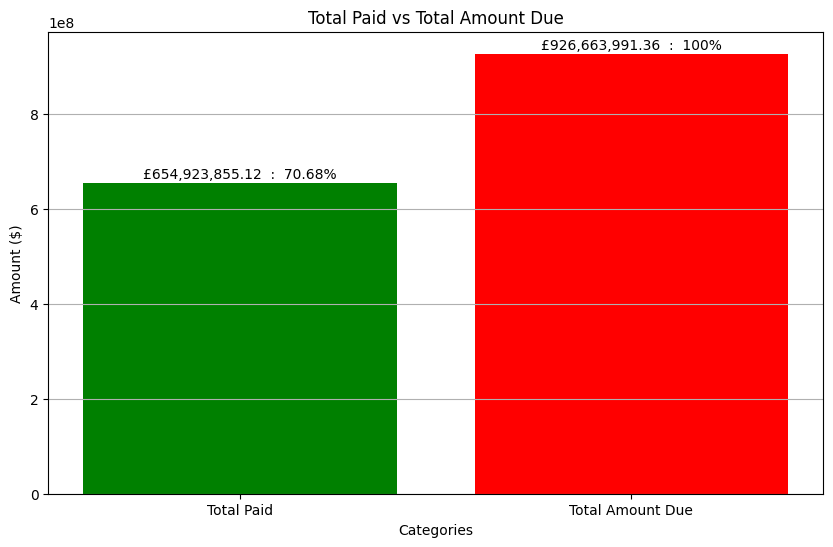

In [7]:
total_paid = df_analyse['total_payment'].sum()
total_to_pay = df_analyse['total_amount_due'].sum()
labels = ['Total Paid', 'Total Amount Due']
values = [total_paid, total_to_pay]
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['green', 'red'])
plt.title('Total Paid vs Total Amount Due')
plt.ylabel('Amount ($)')
plt.xlabel('Categories')
plt.grid(axis='y')

plt.text(0, total_paid + 1e7, f'£{total_paid:,.2f}  :  {alt_paid:.2f}%', ha='center')
plt.text(1, total_to_pay + 1e7, f'£{total_to_pay:,.2f}  :  100%', ha='center')

pdf.savefig()

plt.show()


As of the latest data, borrowers have repaid approximately 70.68% of the total loan amount. This is a positive indicator of overall repayment reliability across the portfolio, with only 29.32% still outstanding. Monitoring these figures closely can help us anticipate future cash flow.

In [8]:
def compute_new_col(row):
    """Function to calculate the predicted total paid in 1 month"""
    if (row['total_amount_due']) - (row['total_payment'] + row['instalment'])  > 0:
        return row['total_payment'] + row['instalment']
    else:
        return row['total_payment']
    
df_analyse['1_month'] = df_analyse.apply(compute_new_col, axis=1)

print(f"The total amount paid after 1 additional month is £{(df_analyse['1_month'].sum().round(2))}")
percentage_paid_1_month = (df_analyse['1_month'].sum() / df_analyse['total_amount_due'].sum()*100)
print(f"The percentage of loans paid after 1 month is {percentage_paid_1_month.round(2)} %")


The total amount paid after 1 additional month is £672321066.81
The percentage of loans paid after 1 month is 72.55 %


In [9]:
def calculate_monthly_payment(row, months):
    """Calculates the total payment made after a given number of months."""
    remaining_due = row['total_amount_due'] - (row['total_payment'] + (months * row['instalment']))
    
    if remaining_due > 0:
        return row['total_payment'] + (months * row['instalment'])
    return row['total_payment']

def running_monthly_total(df, max_months=6):
    """Generates a DataFrame summarizing total payments for each month up to max_months."""
    summary_data = []
    total_due_amount = df['total_amount_due'].sum()
    
    for month in range(max_months + 1):
        cumulative_payment = df.apply(calculate_monthly_payment, axis=1, months=month).sum()
        percentage_paid = (100 * cumulative_payment / total_due_amount).round(2)
        
        summary_data.append({
            'months': month,
            'total_paid': cumulative_payment,
            'full_amount_due': total_due_amount,
            'percentage_paid': percentage_paid
        })
        
    return pd.DataFrame(summary_data)

# Create the summary DataFrame
running_total_df = running_monthly_total(df_analyse)

# Print the summary DataFrame
print(running_total_df)

   months    total_paid  full_amount_due  percentage_paid
0       0  6.549239e+08     9.266640e+08            70.68
1       1  6.723211e+08     9.266640e+08            72.55
2       2  6.864008e+08     9.266640e+08            74.07
3       3  6.986017e+08     9.266640e+08            75.39
4       4  7.099289e+08     9.266640e+08            76.61
5       5  7.209465e+08     9.266640e+08            77.80
6       6  7.316914e+08     9.266640e+08            78.96


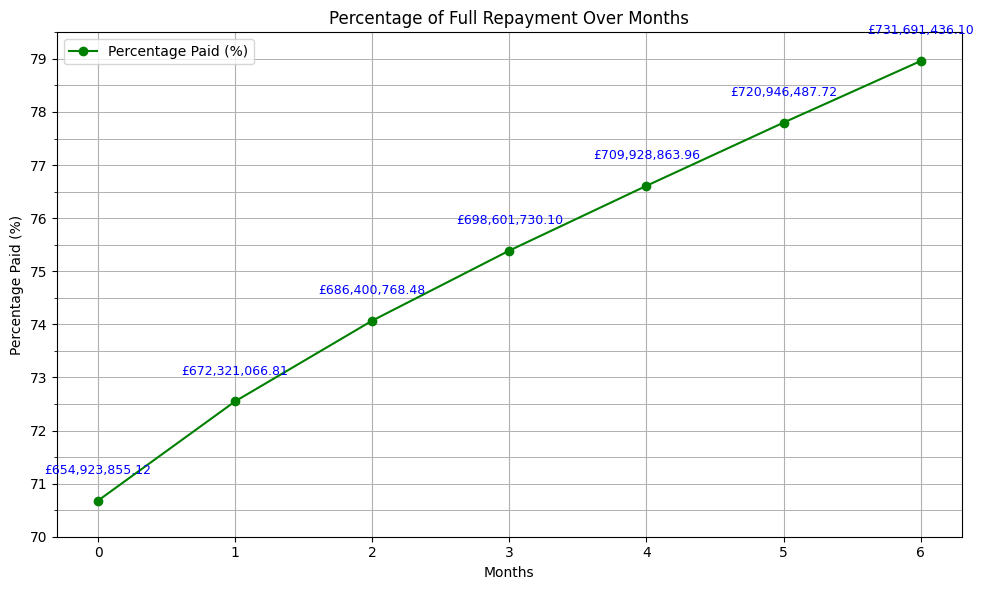

In [10]:
# Create a plot for percentage of full repayment over months
plt.figure(figsize=(10, 6))

# Plot percentage paid over months
plt.plot(running_total_df['months'], running_total_df['percentage_paid'], marker='o', color='green', label='Percentage Paid (%)')
plt.title('Percentage of Full Repayment Over Months')
plt.xlabel('Months')
plt.ylabel('Percentage Paid (%)')
# Set y-ticks to show every 0.5 increment
y_ticks = np.arange(70, 80, 1)  # Adjust this range if necessary
# Add grid lines at every 0.5 increment
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.7)
plt.gca().set_yticks(np.arange(70.5, 80, 0.5), minor=True)  # Minor ticks for grid lines
plt.yticks(y_ticks)
plt.grid(True)

# Add data labels (total_paid amounts) on the plot
for i, row in running_total_df.iterrows():
    plt.text(row['months'], row['percentage_paid'] + 0.5, f'£{row["total_paid"]:,.2f}', 
                ha='center', color='blue', fontsize=9)

plt.legend()
plt.tight_layout()  # Adjust layout for readability
pdf.savefig()
plt.show()

There is a consistent increase in the percentage of total repayments over time, which demonstrates strong repayment behavior among borrowers. Maintaining support mechanisms for timely payers could reinforce this trend and minimize late or missed payments.

## Calculating Loss

In [11]:
charged_off_loans = df_analyse[df_analyse['loan_status'].isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'])]

In [12]:
charged_pct = (charged_off_loans.shape[0] / df_analyse.shape[0]) * 100
charged_pct

10.828978227548891

In [13]:
print(f"Out of a total of {(df_analyse.shape[0])}, there are {(charged_off_loans.shape[0])} that have been charged off. \nThis equates to {charged_pct:.2f} of all the loans in the database. ")

Out of a total of 54151, there are 5864 that have been charged off. 
This equates to 10.83 of all the loans in the database. 


In [14]:
print(f"The charged off loans were for a total amount of £{charged_off_loans['loan_amount'].sum():,.2f}.")
print(f"The charged off loans were worth a total amount of £{charged_off_loans['total_amount_due'].sum():,.2f} if paid in full.")
print(f"The total amount repaid on these loans was £{charged_off_loans['total_payment'].sum():,.2f}.")
charged_off_loss = (charged_off_loans['total_amount_due'].sum()) - (charged_off_loans['total_payment'].sum())
print(f"This represents a loss of £{charged_off_loss:,.2f}.")

print(f"The total value of the portfolio is £{df_analyse['total_amount_due'].sum():,.2f}.")

percentage_loss = ((charged_off_loss / df_analyse['total_amount_due'].sum()) * 100)

print(f"This loss of represents {percentage_loss:.2f}% of the overall value of the loan portfolio.")

The charged off loans were for a total amount of £79,287,750.00.
The charged off loans were worth a total amount of £105,669,391.92 if paid in full.
The total amount repaid on these loans was £39,151,684.33.
This represents a loss of £66,517,707.59.
The total value of the portfolio is £926,663,991.36.
This loss of represents 7.18% of the overall value of the loan portfolio.


## Calculating Projected Loss

In [15]:
def compute_loss_for_months(row, months):
    """Function that calculates the loss for a given number of months"""
    if (row['total_amount_due'] - (row['total_payment'] + (months * row['instalment']))) > 0:
        return row['instalment']
    else:
        return 0

 
def create_loss_dataframe(df, max_months=60):
    """Function that creates a new DataFrame with total sums for 0 to 60 months"""
    results = []
    for month in range(max_months + 1):
        total_loss = df.apply(compute_loss_for_months, axis=1, months=month).sum()
        results.append({'months': month, 'total_loss': (total_loss / 1000000)})  # Convert values into millions to remove exponential values in new dataframe.
    return pd.DataFrame(results)


loss_df = create_loss_dataframe(charged_off_loans)      # Create a summary DataFrame
loss_df['cumulative_loss'] = (loss_df['total_loss']).cumsum()

print(loss_df)


    months  total_loss  cumulative_loss
0        0    2.324242         2.324242
1        1    2.316027         4.640268
2        2    2.306141         6.946409
3        3    2.296932         9.243341
4        4    2.285662        11.529003
..     ...         ...              ...
56      56    0.041866        67.988096
57      57    0.021103        68.009200
58      58    0.010944        68.020143
59      59    0.004053        68.024196
60      60    0.000000        68.024196

[61 rows x 3 columns]


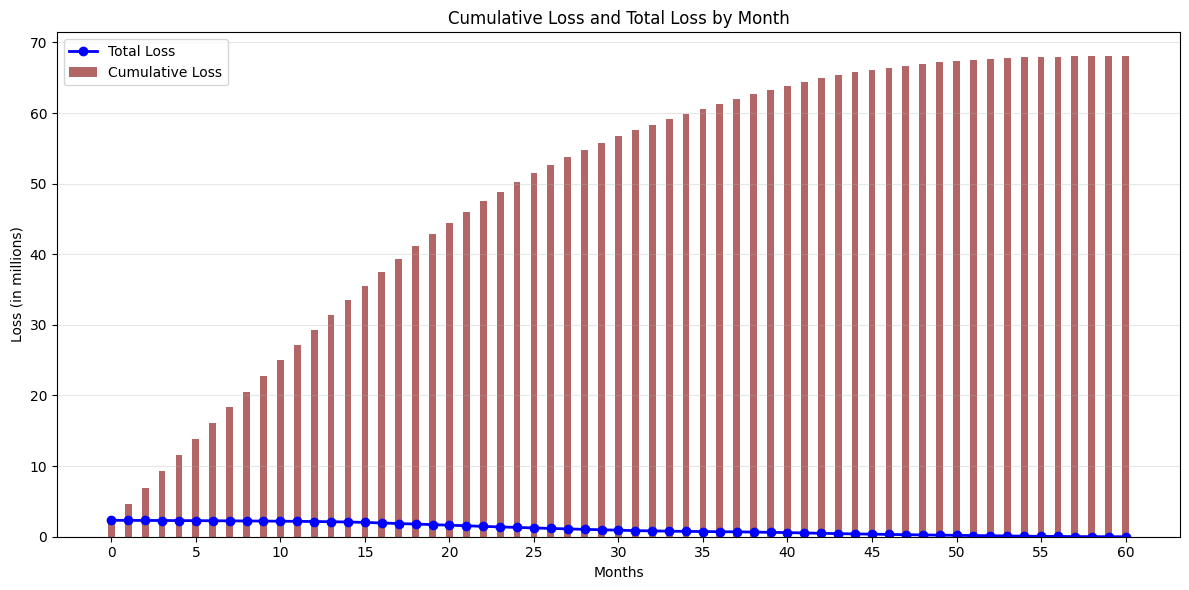

In [16]:
def plot_combined_chart_single_axis(data):
    plt.figure(figsize=(12, 6))

    # Bar chart for cumulative loss
    plt.bar(data['months'], data['cumulative_loss'], color='maroon', alpha=0.6, label='Cumulative Loss', width=0.4, align='center')

    # Line chart for total loss
    plt.plot(data['months'], data['total_loss'], color='blue', marker='o', label='Total Loss', linewidth=2)

    # Labels and title
    plt.xlabel('Months')
    plt.ylabel('Loss (in millions)')
    plt.title('Cumulative Loss and Total Loss by Month')

    # Adding legend
    plt.legend()

    # Adding grid
    plt.grid(axis='y', alpha=0.3)

    # Show the plot
    plt.xticks(ticks=range(0, len(data), 5), labels=data['months'][::5])  # Ensure all month labels are displayed
    plt.tight_layout()  # Ensure everything fits without overlap
    pdf.savefig()
    plt.show()

plot_combined_chart_single_axis(loss_df)

Cumulative losses are steadily increasing, indicating a persistent risk in loan repayments. To address this, a proactive approach in managing accounts with early signs of risk can help reduce cumulative loss impact over time.

## Possible Loss

In [17]:
# Filter customers who are behind on their payments
late_customers = df_analyse[df_analyse['loan_status'].str.contains('Late')].copy()
late_customers.head()  # Display a few rows to confirm the filtering

,id,member_id,loan_amount,funded_amount_inv,term (months),int_rate,instalment,grade,sub_grade,employment_length (years),...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type,total_amount_due,1_month
17,38655869,41439673,18825.0,18825.0,60,13.66,434.72,C,C3,10+,...,0.0,0.0,2021-10-01,434.72,2022-01-01,0.0,1,INDIVIDUAL,26083.20,4318.63
140,38644147,41427862,15600.0,15600.0,36,14.99,540.71,C,C5,7,...,0.0,0.0,2021-11-01,540.71,2022-01-01,0.0,1,INDIVIDUAL,19465.56,5934.82
168,38635317,41419102,6000.0,6000.0,36,8.67,189.88,B,B1,10+,...,0.0,0.0,2021-11-01,394.76,2022-01-01,0.0,1,INDIVIDUAL,6835.68,2097.90
171,38635273,41419056,15000.0,15000.0,36,13.16,471.37,A,A5,5,...,0.0,0.0,2021-09-01,471.37,2021-09-01,0.0,1,INDIVIDUAL,16969.32,4235.51
243,38625326,41409103,5000.0,5000.0,36,11.44,164.74,B,B4,9,...,0.0,0.0,2021-12-01,164.74,2022-01-01,0.0,1,INDIVIDUAL,5930.64,1973.70


In [18]:
# Calculate the total number of late customers
total_late_customers = late_customers.shape[0]
print(f"Total Late Customers: {total_late_customers}")

Total Late Customers: 686


In [19]:
# Calculate the total amount of loans for late customers
total_late_amount = late_customers['loan_amount'].sum()
print(f"Total Amount for Late Customers: ${total_late_amount:.2f}")

Total Amount for Late Customers: $10302800.00


In [20]:
# Prepare and calculate expected loss if they were to be charged off
late_customers['term (months)'] = late_customers['term (months)'].astype(int)
late_customers['remaining_term'] = late_customers['term (months)'] - (late_customers['total_payment'] / late_customers['instalment'])
late_customers['expected_loss'] = late_customers['remaining_term'] * late_customers['instalment']

# Calculate total expected loss for late customers
total_expected_loss_late = late_customers['expected_loss'].sum()
print(f"Projected Loss from Late Customers if Charged Off: ${total_expected_loss_late:.2f}")


Projected Loss from Late Customers if Charged Off: $7316814.49


In [21]:
# Calculate total expected revenue
total_revenue = df_analyse['loan_amount'].sum()
print(f"Total Expected Revenue: ${total_revenue:.2f}")

Total Expected Revenue: $722297925.00


In [22]:
# Calculate the percentage of late customers compared to total customers
total_customers = df_analyse.shape[0]
percentage_late_customers = (total_late_customers / total_customers) * 100 if total_customers > 0 else 0
print(f"Percentage of Customers Late on Payments: {percentage_late_customers:.2f}%")


Percentage of Customers Late on Payments: 1.27%


In [23]:
# Filter and calculate expected loss for charged off loans
charged_off_loans = df_analyse[df_analyse['loan_status'] == 'Charged Off'].copy()
charged_off_loans['term (months)'] = charged_off_loans['term (months)'].astype(int)
charged_off_loans['remaining_term'] = charged_off_loans['term (months)'] - (charged_off_loans['total_payment'] / charged_off_loans['instalment'])
charged_off_loans['expected_loss'] = charged_off_loans['remaining_term'] * charged_off_loans['instalment']

# Calculate total expected loss for charged off loans
total_charged_off_loss = charged_off_loans['expected_loss'].sum()
print(f"Total Expected Loss from Charged Off Loans: ${total_charged_off_loss:.2f}")

Total Expected Loss from Charged Off Loans: $63891804.88


In [24]:
# Calculate the combined loss and its percentage of total expected revenue
combined_loss = total_expected_loss_late + total_charged_off_loss
percentage_combined_loss = (combined_loss / total_revenue) * 100 if total_revenue > 0 else 0
print(f"Percentage of Total Expected Revenue from Late and Charged Off Loans: {percentage_combined_loss:.2f}%")


Percentage of Total Expected Revenue from Late and Charged Off Loans: 9.86%


In [25]:
# Store results in a dictionary for final output
results = {
    "total_late_customers": total_late_customers,
    "total_late_amount": total_late_amount,
    "total_expected_loss_late": total_expected_loss_late,
    "percentage_late_customers": percentage_late_customers,
    "percentage_combined_loss": percentage_combined_loss
}

# Display the results with descriptive phrases for each key-value pair
print(f"There are currently {results['total_late_customers']} customers who are late on their loan payments, representing a notable portion of the overall customer base.\n")
print(f"The total loan amount owed by these late-paying customers is approximately ${results['total_late_amount']:.2f}, highlighting the level of outstanding risk associated with delayed payments.\n")
print(f"If all late customers were to default, the projected loss would amount to about ${results['total_expected_loss_late']:.2f}, underscoring the potential financial impact of non-repayment.\n")
print(f"Currently, {results['percentage_late_customers']:.2f}% of our customers are behind on their payments, which serves as an indicator of overall portfolio health.\n")
print(f"Combined, the late and charged-off loans represent {results['percentage_combined_loss']:.2f}% of our total expected revenue, pointing to the proportion of revenue at risk due to these segments.\n")

There are currently 686 customers who are late on their loan payments, representing a notable portion of the overall customer base.

The total loan amount owed by these late-paying customers is approximately $10302800.00, highlighting the level of outstanding risk associated with delayed payments.

If all late customers were to default, the projected loss would amount to about $7316814.49, underscoring the potential financial impact of non-repayment.

Currently, 1.27% of our customers are behind on their payments, which serves as an indicator of overall portfolio health.

Combined, the late and charged-off loans represent 9.86% of our total expected revenue, pointing to the proportion of revenue at risk due to these segments.



## Indicators of Loss

In [26]:
df_analyse['loan_status'].unique()

array(['Current', 'Fully Paid', 'Charged Off', 'Late (31-120 days)',
       'In Grace Period', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [27]:
# Grouping by 'grade' and calculating counts for each loan status
grade_counts = df_analyse.groupby(['grade', 'loan_status']).size().unstack(fill_value=0)

# Calculate the total counts for fully paid, charged off, and late
grade_counts['Total'] = grade_counts.sum(axis=1)

# Calculate percentages
grade_counts_percentage = grade_counts.div(grade_counts['Total'], axis=0) * 100

# Renaming columns for clarity
grade_counts_percentage = grade_counts_percentage.rename(columns={
    'Fully Paid': 'Fully Paid Percentage',
    'Charged Off': 'Charged Off Percentage',
    'Late': 'Late Percentage',
    'Does not meet credit policy: Fully Paid': 'Policy Fully Paid Percentage'
})

# Display the table
grade_counts_percentage


loan_status,Charged Off Percentage,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid Percentage,In Grace Period,Late (16-30 days),Late (31-120 days),Total
grade,,,,,,,,,,
A,4.300856,30.442316,0.000000,0.030575,0.417856,64.390542,0.142682,0.061150,0.214024,100.0
B,7.827310,36.678285,0.073381,0.244603,0.764386,52.938299,0.415826,0.140647,0.917263,100.0
C,10.805834,39.569829,0.132587,0.530348,1.789923,45.256335,0.545080,0.191514,1.178550,100.0
D,14.362944,35.594053,0.196584,1.032068,3.010198,43.064259,0.774051,0.331736,1.634107,100.0
E,17.257509,33.554899,0.073855,1.944855,4.775972,39.364845,0.713934,0.393895,1.920236,100.0
F,21.242604,31.479290,0.177515,2.307692,4.378698,37.692308,0.828402,0.295858,1.597633,100.0
G,20.231214,22.736031,0.000000,8.477842,11.946050,33.333333,0.578035,0.578035,2.119461,100.0


In [28]:
paid_df = df_analyse[df_analyse['loan_status'].str.contains('Fully Paid')]
late_df = df_analyse[df_analyse['loan_status'].str.contains('Late')]
charged_df = df_analyse[df_analyse['loan_status'].str.contains('Charged Off')]

In [29]:
# Count the number of rows for each DataFrame
count_paid = paid_df.shape[0]
count_late = late_df.shape[0]
count_charged = charged_df.shape[0]

# Display the counts
print(f"Count of Fully Paid Loans: {count_paid}")
print(f"Count of Late Loans: {count_late}")
print(f"Count of Charged Off Loans: {count_charged}")
print(f"Total: {count_paid + count_late + count_charged }")
print(f'Total in df:{df_analyse.shape[0]}')


Count of Fully Paid Loans: 28017
Count of Late Loans: 686
Count of Charged Off Loans: 5864
Total: 34567
Total in df:54151


### For Grade of Loans

In [30]:
# Grouping by 'grade' and calculating counts for each loan status
paid_counts = paid_df.groupby('grade').size()
late_counts = late_df.groupby('grade').size()
charged_counts = charged_df.groupby('grade').size()

# Combining counts into a single DataFrame
grade_counts = pd.DataFrame({
    'Fully Paid': paid_counts,
    'Late': late_counts,
    'Charged Off': charged_counts
}).fillna(0)  # Filling NaN with 0

# Calculate the total counts for each grade type
grade_counts['Total'] = grade_counts.sum(axis=1)

# Calculate percentages
grade_counts_percentage = grade_counts.div(grade_counts['Total'], axis=0) * 100

# Rounding to 3 decimal places
grade_counts_percentage = grade_counts_percentage.round(3)

# Renaming columns for clarity
grade_counts_percentage = grade_counts_percentage.rename(columns={
    'Fully Paid': 'Fully Paid Percentage',
    'Charged Off': 'Charged Off Percentage',
    'Late': 'Late Percentage'
})

# Display the table
grade_counts_percentage


,Fully Paid Percentage,Late Percentage,Charged Off Percentage,Total
grade,,,,
A,93.364,0.396,6.240,100.0
B,85.470,1.684,12.847,100.0
C,78.735,2.293,18.972,100.0
D,72.632,3.099,24.269,100.0
E,67.229,3.525,29.246,100.0
F,62.314,2.805,34.882,100.0
G,59.045,3.518,37.437,100.0


In [31]:
# Group by 'grade' and count the occurrences for each loan status
paid_counts = paid_df.groupby('grade').size()
late_counts = late_df.groupby('grade').size()
charged_counts = charged_df.groupby('grade').size()

# Combine the counts into a single DataFrame
summary_counts = pd.DataFrame({
    'Fully Paid': paid_counts,
    'Late': late_counts,
    'Charged Off': charged_counts
}).fillna(0)  # Fill NaNs with 0

# Calculate total loans for each grade
summary_counts['Total'] = summary_counts.sum(axis=1)

# Calculate percentage for each loan status
grade_pct = summary_counts[['Fully Paid', 'Late', 'Charged Off']].div(summary_counts['Total'], axis=0) * 100


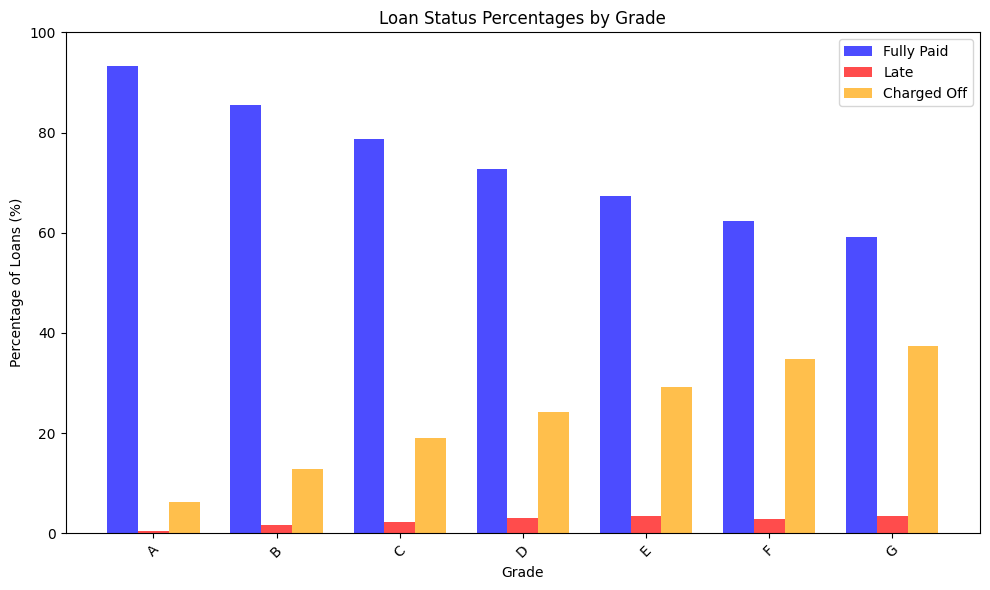

In [32]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the bar width
bar_width = 0.25

# Define the positions for each set of bars
x = np.arange(len(grade_pct.index))

# Create bars for each loan status as percentages
plt.bar(x - bar_width, grade_pct['Fully Paid'], width=bar_width, color='blue', label='Fully Paid', alpha=0.7)
plt.bar(x, grade_pct['Late'], width=bar_width, color='red', label='Late', alpha=0.7)
plt.bar(x + bar_width, grade_pct['Charged Off'], width=bar_width, color='orange', label='Charged Off', alpha=0.7)

# Adding titles and labels
plt.title('Loan Status Percentages by Grade')
plt.xlabel('Grade')
plt.ylabel('Percentage of Loans (%)')
plt.xticks(x, grade_pct.index, rotation=45)
plt.ylim(0, 100)  # Set y-axis limit to 100% for better visualization
plt.legend()
plt.tight_layout()
pdf.savefig()

# Show the plot
plt.show()



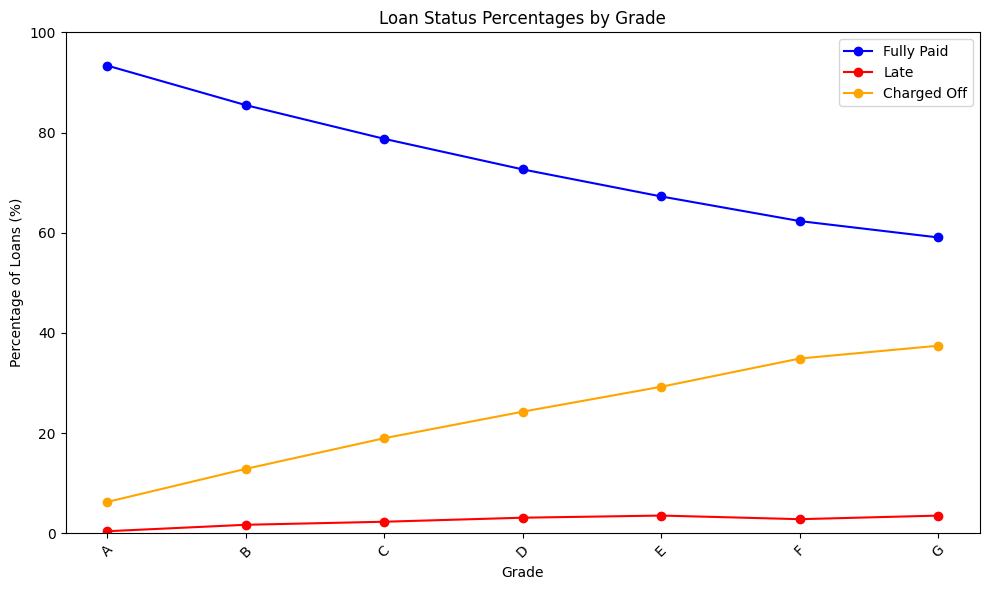

In [33]:
# Plotting for Grade as Line Chart
plt.figure(figsize=(10, 6))

# Plot lines for each loan status as percentages
plt.plot(grade_pct.index, grade_pct['Fully Paid'], label='Fully Paid', color='blue', marker='o')
plt.plot(grade_pct.index, grade_pct['Late'], label='Late', color='red', marker='o')
plt.plot(grade_pct.index, grade_pct['Charged Off'], label='Charged Off', color='orange', marker='o')

# Adding titles and labels
plt.title('Loan Status Percentages by Grade')
plt.xlabel('Grade')
plt.ylabel('Percentage of Loans (%)')
plt.ylim(0, 100)  # Set y-axis limit to 100% for better visualization
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
pdf.savefig()

# Show the plot
plt.show()


Higher-grade loans (A-C) show better repayment rates and fewer charge-offs, while lower grades experience more late payments and defaults. Tightening credit checks or adjusting interest rates for lower-grade loans could improve repayment rates in these segments.

#### For Loan Purpose

In [34]:
# Group by 'purpose' and count the occurrences for each loan status
paid_counts = paid_df.groupby('purpose').size()
late_counts = late_df.groupby('purpose').size()
charged_counts = charged_df.groupby('purpose').size()

# Combine the counts into a single DataFrame
summary_counts = pd.DataFrame({
    'Fully Paid': paid_counts,
    'Late': late_counts,
    'Charged Off': charged_counts
}).fillna(0)  # Fill NaNs with 0

# Calculate total loans for each purpose
summary_counts['Total'] = summary_counts.sum(axis=1)

# Calculate percentage for each loan status
purpose_pct = summary_counts[['Fully Paid', 'Late', 'Charged Off']].div(summary_counts['Total'], axis=0) * 100


In [35]:
# Grouping by 'purpose' and calculating counts for each loan status
paid_counts = paid_df.groupby('purpose').size()
late_counts = late_df.groupby('purpose').size()
charged_counts = charged_df.groupby('purpose').size()

# Combining counts into a single DataFrame
purpose_counts = pd.DataFrame({
    'Fully Paid': paid_counts,
    'Late': late_counts,
    'Charged Off': charged_counts
}).fillna(0)  # Filling NaN with 0

# Calculate the total counts for each purpose type
purpose_counts['Total'] = purpose_counts.sum(axis=1)

# Calculate percentages
purpose_counts_percentage = purpose_counts.div(purpose_counts['Total'], axis=0) * 100

# Rounding to 3 decimal places
purpose_counts_percentage = purpose_counts_percentage.round(3)

# Renaming columns for clarity
purpose_counts_percentage = purpose_counts_percentage.rename(columns={
    'Fully Paid': 'Fully Paid Percentage',
    'Charged Off': 'Charged Off Percentage',
    'Late': 'Late Percentage'
})

# Display the table
purpose_counts_percentage




,Fully Paid Percentage,Late Percentage,Charged Off Percentage,Total
purpose,,,,
car,87.636,0.606,11.758,100.0
credit_card,82.836,2.284,14.880,100.0
debt_consolidation,80.094,2.377,17.530,100.0
educational,79.899,0.000,20.101,100.0
home_improvement,84.619,1.633,13.748,100.0
house,83.395,0.738,15.867,100.0
major_purchase,86.476,0.526,12.998,100.0
medical,80.380,1.055,18.565,100.0
moving,79.235,1.366,19.399,100.0


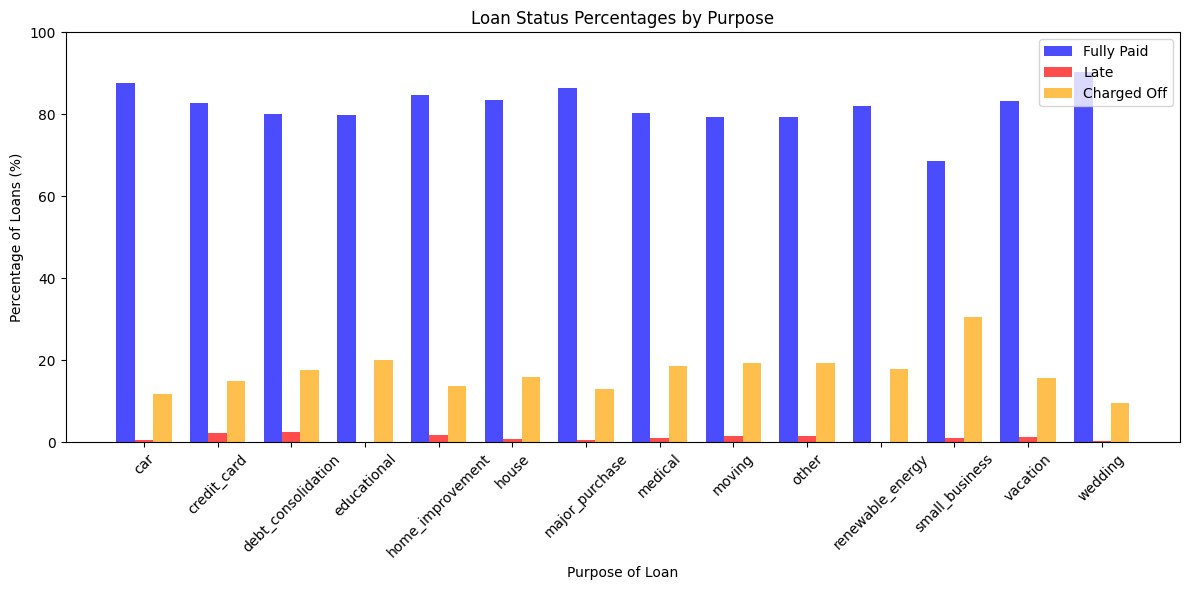

In [36]:
# Plotting
plt.figure(figsize=(12, 6))

# Define the bar width
bar_width = 0.25

# Define the positions for each set of bars
x = np.arange(len(purpose_pct.index))

# Create bars for each loan status as percentages
plt.bar(x - bar_width, purpose_pct['Fully Paid'], width=bar_width, color='blue', label='Fully Paid', alpha=0.7)
plt.bar(x, purpose_pct['Late'], width=bar_width, color='red', label='Late', alpha=0.7)
plt.bar(x + bar_width, purpose_pct['Charged Off'], width=bar_width, color='orange', label='Charged Off', alpha=0.7)

# Adding titles and labels
plt.title('Loan Status Percentages by Purpose')
plt.xlabel('Purpose of Loan')
plt.ylabel('Percentage of Loans (%)')
plt.xticks(x, purpose_pct.index, rotation=45)
plt.ylim(0, 100)  # Set y-axis limit to 100% for better visualization
plt.legend()
plt.tight_layout()
pdf.savefig()

# Show the plot
plt.show()


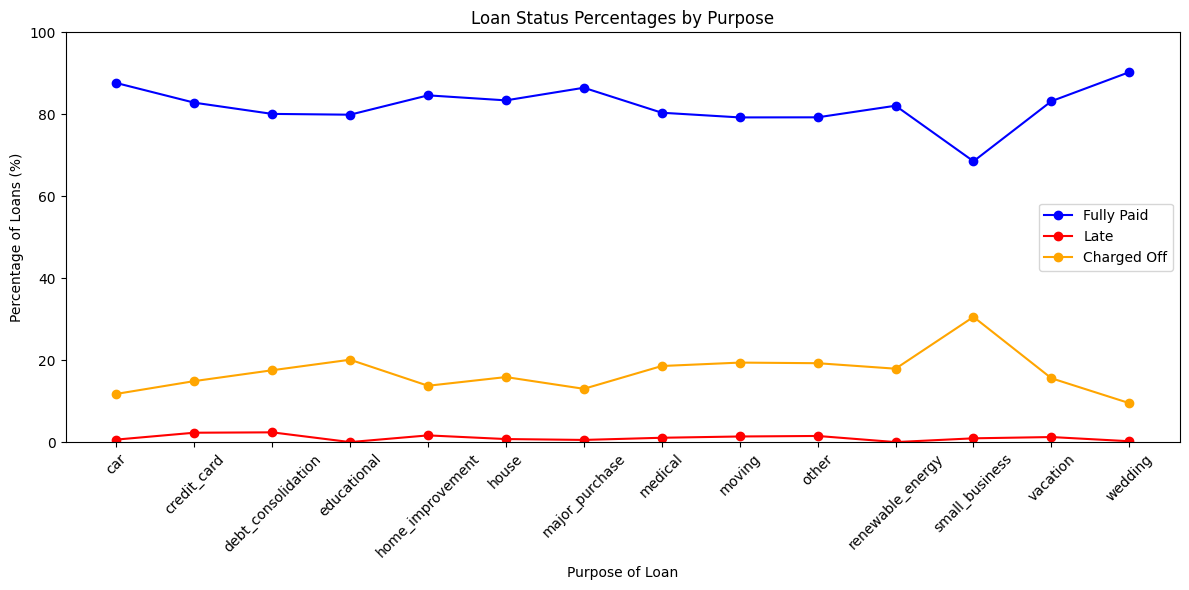

In [37]:
# Plotting for Purpose as Line Chart
plt.figure(figsize=(12, 6))

# Plot lines for each loan status
plt.plot(purpose_pct.index, purpose_pct['Fully Paid'], label='Fully Paid', color='blue', marker='o')
plt.plot(purpose_pct.index, purpose_pct['Late'], label='Late', color='red', marker='o')
plt.plot(purpose_pct.index, purpose_pct['Charged Off'], label='Charged Off', color='orange', marker='o')

# Adding titles and labels
plt.title('Loan Status Percentages by Purpose')
plt.xlabel('Purpose of Loan')
plt.ylabel('Percentage of Loans (%)')
plt.ylim(0, 100)  # Set y-axis limit to 100% for better visualization
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
pdf.savefig()

# Show the plot
plt.show()


Debt consolidation loans demonstrate a high repayment rate, while small business loans have a higher rate of defaults and late payments. Increasing lending in categories like debt consolidation could strengthen portfolio stability, while small business loans may need stricter credit evaluations.

#### For Home Ownership

In [38]:
# Grouping by 'home_ownership' and calculating counts for each loan status
paid_counts = paid_df.groupby('home_ownership').size()
late_counts = late_df.groupby('home_ownership').size()
charged_counts = charged_df.groupby('home_ownership').size()

# Combining counts into a single DataFrame
home_ownership_counts = pd.DataFrame({
    'Fully Paid': paid_counts,
    'Late': late_counts,
    'Charged Off': charged_counts
}).fillna(0)  # Filling NaN with 0

# Calculate the total counts for each home ownership type
home_ownership_counts['Total'] = home_ownership_counts.sum(axis=1)

# Calculate percentages
home_ownership_counts_percentage = home_ownership_counts.div(home_ownership_counts['Total'], axis=0) * 100

# Rounding to 3 decimal places
home_ownership_counts_percentage = home_ownership_counts_percentage.round(3)

# Renaming columns for clarity
home_ownership_counts_percentage = home_ownership_counts_percentage.rename(columns={
    'Fully Paid': 'Fully Paid Percentage',
    'Charged Off': 'Charged Off Percentage',
    'Late': 'Late Percentage'
})

# Display the table
home_ownership_counts_percentage



,Fully Paid Percentage,Late Percentage,Charged Off Percentage,Total
home_ownership,,,,
MORTGAGE,82.471,1.858,15.671,100.0
NONE,50.000,0.000,50.000,100.0
OTHER,77.778,0.000,22.222,100.0
OWN,78.953,2.443,18.604,100.0
RENT,79.914,2.045,18.041,100.0


In [39]:
# Group by 'home_ownership' and count the occurrences for each loan status
paid_counts = paid_df.groupby('home_ownership').size()
late_counts = late_df.groupby('home_ownership').size()
charged_counts = charged_df.groupby('home_ownership').size()

# Combine the counts into a single DataFrame
summary_counts = pd.DataFrame({
    'Fully Paid': paid_counts,
    'Late': late_counts,
    'Charged Off': charged_counts
}).fillna(0)  # Fill NaNs with 0

# Calculate total loans for each home ownership status
summary_counts['Total'] = summary_counts.sum(axis=1)

# Calculate percentage for each loan status
ownership_pct = summary_counts[['Fully Paid', 'Late', 'Charged Off']].div(summary_counts['Total'], axis=0) * 100


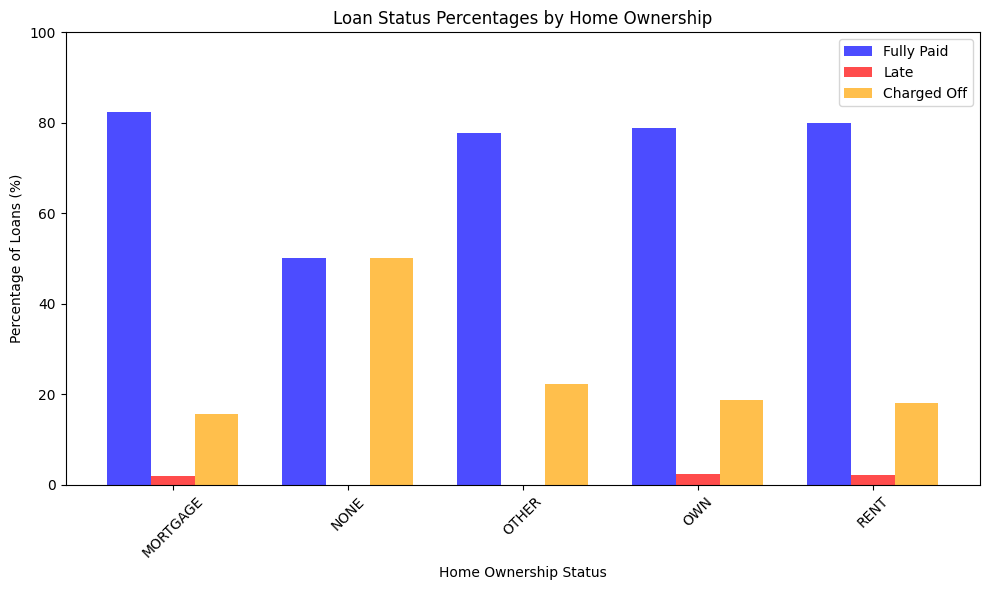

In [40]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the bar width
bar_width = 0.25

# Define the positions for each set of bars
x = np.arange(len(ownership_pct.index))

# Create bars for each loan status as percentages
plt.bar(x - bar_width, ownership_pct['Fully Paid'], width=bar_width, color='blue', label='Fully Paid', alpha=0.7)
plt.bar(x, ownership_pct['Late'], width=bar_width, color='red', label='Late', alpha=0.7)
plt.bar(x + bar_width, ownership_pct['Charged Off'], width=bar_width, color='orange', label='Charged Off', alpha=0.7)

# Adding titles and labels
plt.title('Loan Status Percentages by Home Ownership')
plt.xlabel('Home Ownership Status')
plt.ylabel('Percentage of Loans (%)')
plt.xticks(x, ownership_pct.index, rotation=45)
plt.ylim(0, 100)  # Set y-axis limit to 100% for better visualization
plt.legend()
plt.tight_layout()
pdf.savefig()

# Show the plot
plt.show()


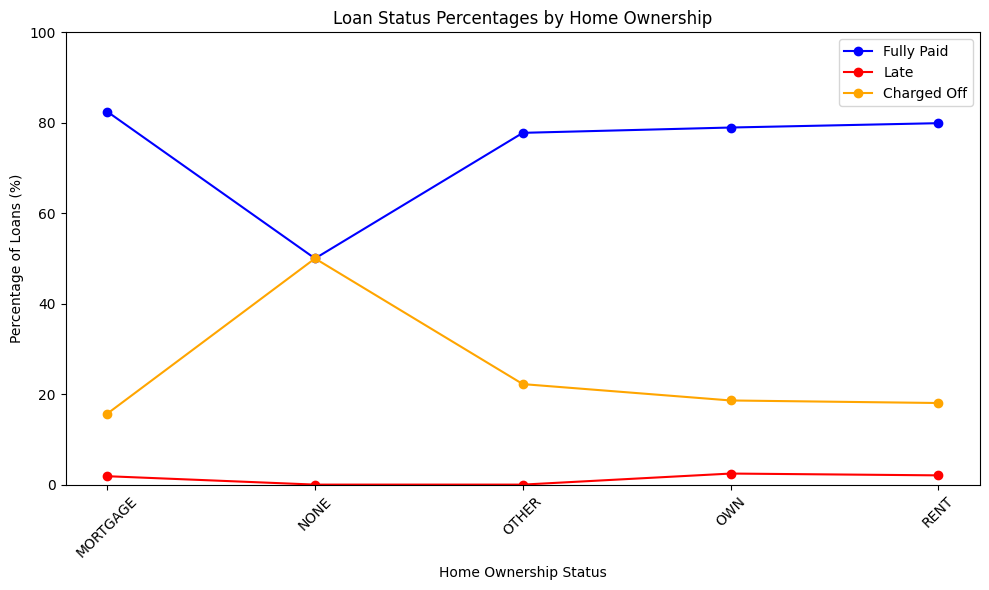

In [41]:
# Plotting for Home Ownership as Line Chart
plt.figure(figsize=(10, 6))

# Plot lines for each loan status
plt.plot(ownership_pct.index, ownership_pct['Fully Paid'], label='Fully Paid', color='blue', marker='o')
plt.plot(ownership_pct.index, ownership_pct['Late'], label='Late', color='red', marker='o')
plt.plot(ownership_pct.index, ownership_pct['Charged Off'], label='Charged Off', color='orange', marker='o')

# Adding titles and labels
plt.title('Loan Status Percentages by Home Ownership')
plt.xlabel('Home Ownership Status')
plt.ylabel('Percentage of Loans (%)')
plt.ylim(0, 100)  # Set y-axis limit to 100% for better visualization
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
pdf.savefig()

# Show the plot
plt.show()

Borrowers with mortgages or owned homes have a higher likelihood of fully repaying their loans, while renters show a higher rate of late payments and charge-offs. This suggests that incorporating homeownership status as a risk assessment criterion could improve loan performance.

##### Employment Years

In [42]:
# Grouping by 'employment_length (years)' and calculating counts for each loan status
paid_counts = paid_df.groupby('employment_length (years)').size()
late_counts = late_df.groupby('employment_length (years)').size()
charged_counts = charged_df.groupby('employment_length (years)').size()

# Combining counts into a single DataFrame
employment_counts = pd.DataFrame({
    'Fully Paid': paid_counts,
    'Late': late_counts,
    'Charged Off': charged_counts
}).fillna(0)  # Filling NaN with 0

# Calculate the total counts for each employment length type
employment_counts['Total'] = employment_counts.sum(axis=1)

# Calculate percentages
employment_counts_percentage = employment_counts.div(employment_counts['Total'], axis=0) * 100

# Rounding to 3 decimal places
employment_counts_percentage = employment_counts_percentage.round(3)

# Renaming columns for clarity
employment_counts_percentage = employment_counts_percentage.rename(columns={
    'Fully Paid': 'Fully Paid Percentage',
    'Charged Off': 'Charged Off Percentage',
    'Late': 'Late Percentage'
})

# Defining custom order for 'employment_length (years)'
custom_order = ['< 1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']

# Reindexing the DataFrame to enforce the custom order
employment_counts_percentage = employment_counts_percentage.reindex(custom_order)

# Display the table
employment_counts_percentage



,Fully Paid Percentage,Late Percentage,Charged Off Percentage,Total
employment_length (years),,,,
< 1,81.589,1.343,17.068,100.0
1,82.513,1.418,16.069,100.0
2,82.356,1.887,15.756,100.0
3,81.401,1.401,17.197,100.0
4,83.524,1.390,15.086,100.0
5,81.211,1.562,17.227,100.0
6,80.883,1.856,17.260,100.0
7,81.397,2.179,16.425,100.0
8,82.637,2.154,15.209,100.0


In [43]:
# Define the custom order for employment length categories
employment_order = ['< 1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']

# Convert 'employment_length (years)' to a categorical type with the custom order
df_analyse['employment_length (years)'] = pd.Categorical(df_analyse['employment_length (years)'], categories=employment_order, ordered=True)


In [44]:
# Group by 'employment_length (years)' and count occurrences for each loan status, following the custom order
paid_counts_emp_length = paid_df.groupby('employment_length (years)').size().reindex(employment_order, fill_value=0)
late_counts_emp_length = late_df.groupby('employment_length (years)').size().reindex(employment_order, fill_value=0)
charged_counts_emp_length = charged_df.groupby('employment_length (years)').size().reindex(employment_order, fill_value=0)

# Combine counts into a single DataFrame
summary_counts_emp_length = pd.DataFrame({
    'Fully Paid': paid_counts_emp_length,
    'Late': late_counts_emp_length,
    'Charged Off': charged_counts_emp_length
})

# Calculate total loans for each employment length
summary_counts_emp_length['Total'] = summary_counts_emp_length.sum(axis=1)


In [45]:
# Calculate the percentage for each loan status
percentage_counts_emp_length = summary_counts_emp_length[['Fully Paid', 'Late', 'Charged Off']].div(summary_counts_emp_length['Total'], axis=0) * 100


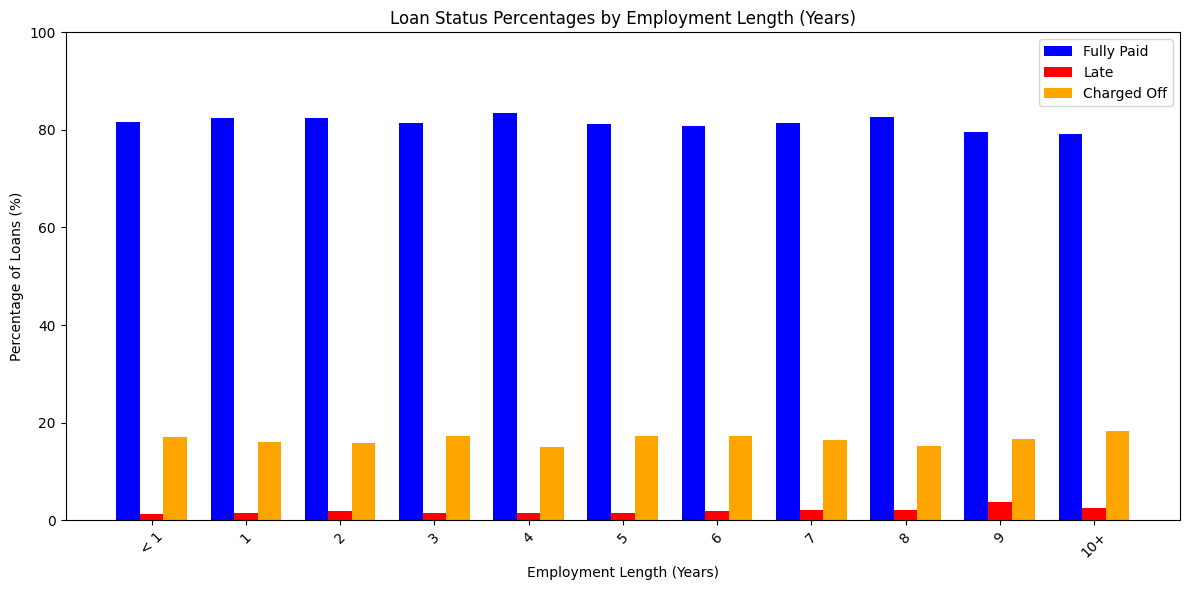

In [46]:
# Define the width of each bar
bar_width = 0.25

# Set positions for each set of bars
x = np.arange(len(percentage_counts_emp_length.index))  # the label locations
positions_fully_paid = x - bar_width
positions_late = x
positions_charged_off = x + bar_width

# Plot each bar for Fully Paid, Late, and Charged Off
plt.figure(figsize=(12, 6))
plt.bar(positions_fully_paid, percentage_counts_emp_length['Fully Paid'], width=bar_width, color='blue', label='Fully Paid')
plt.bar(positions_late, percentage_counts_emp_length['Late'], width=bar_width, color='red', label='Late')
plt.bar(positions_charged_off, percentage_counts_emp_length['Charged Off'], width=bar_width, color='orange', label='Charged Off')

# Adding titles and labels
plt.title('Loan Status Percentages by Employment Length (Years)')
plt.xlabel('Employment Length (Years)')
plt.ylabel('Percentage of Loans (%)')
plt.xticks(x, percentage_counts_emp_length.index, rotation=45)
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
pdf.savefig()

# Show the plot
plt.show()

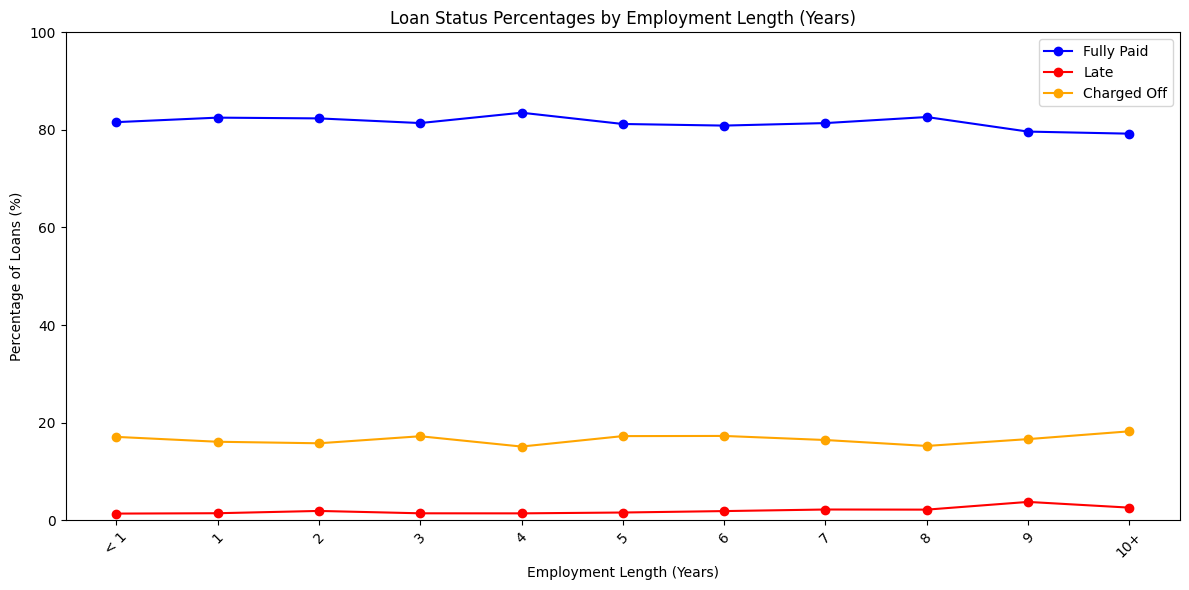

In [47]:
# Plotting for Employment Length (Years) as a Line Chart
plt.figure(figsize=(12, 6))

# Plot lines for each loan status as percentages
plt.plot(percentage_counts_emp_length.index, percentage_counts_emp_length['Fully Paid'], label='Fully Paid', color='blue', marker='o')
plt.plot(percentage_counts_emp_length.index, percentage_counts_emp_length['Late'], label='Late', color='red', marker='o')
plt.plot(percentage_counts_emp_length.index, percentage_counts_emp_length['Charged Off'], label='Charged Off', color='orange', marker='o')

# Adding titles and labels
plt.title('Loan Status Percentages by Employment Length (Years)')
plt.xlabel('Employment Length (Years)')
plt.ylabel('Percentage of Loans (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
pdf.savefig()

# Show the plot
plt.show()

Longer employment histories correlate with higher rates of fully-paid loans, while shorter employment terms see more defaults. Focusing on borrowers with a stable employment background can reduce default rates and strengthen loan performance.

### Annual Income

In [48]:
df_analyse['annual_inc'].quantile(0.95)

np.float64(150000.0)

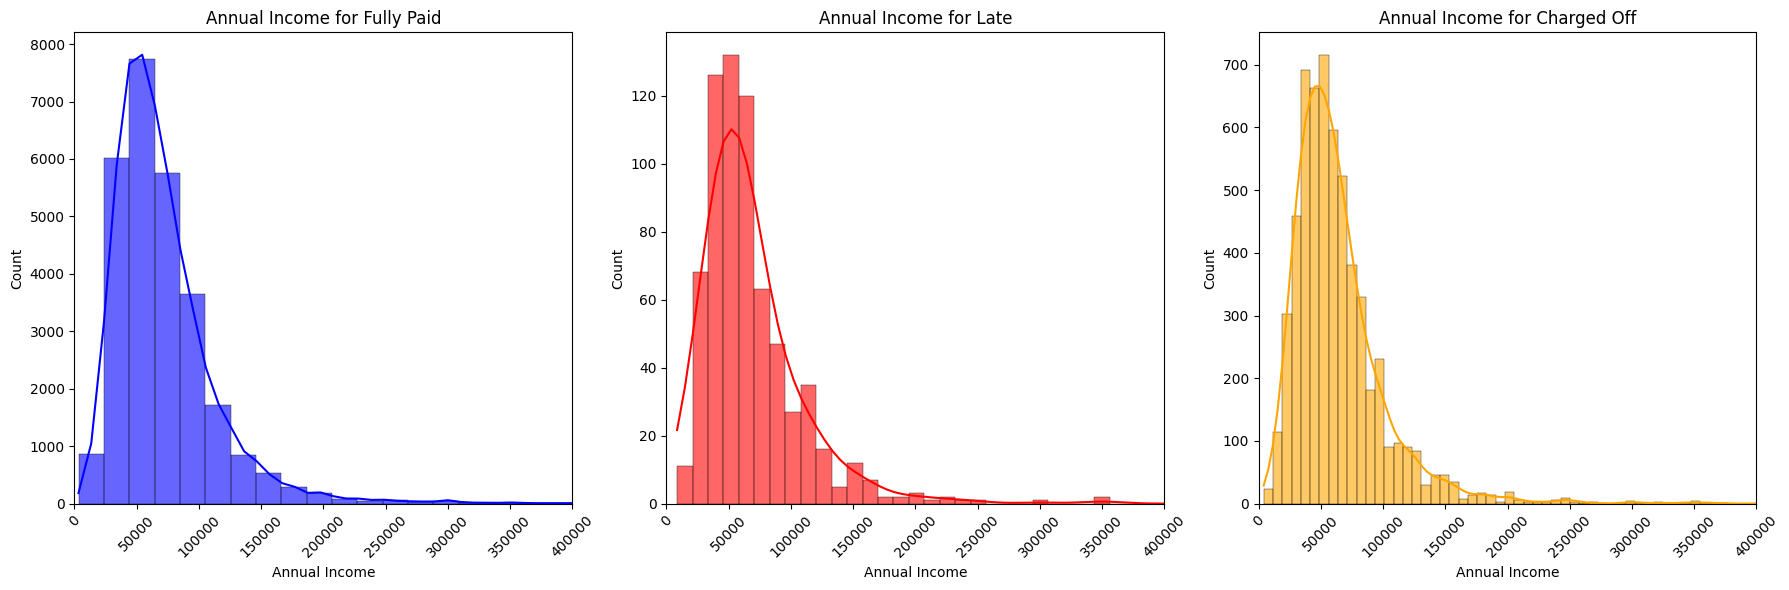

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure and axes for three side-by-side plots without shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the bin size
bin_size = 100

# Histogram for Fully Paid with KDE
sns.histplot(paid_df['annual_inc'], bins=bin_size,
             kde=True, ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title('Annual Income for Fully Paid')
axes[0].set_xlabel('Annual Income')
axes[0].set_ylabel('Count')
axes[0].set_xlim(0, 400000)  # Set x-axis range
axes[0].tick_params(axis='x', rotation=45)

# Histogram for Late with KDE
sns.histplot(late_df['annual_inc'], bins=bin_size,
             kde=True, ax=axes[1], color='red', alpha=0.6)
axes[1].set_title('Annual Income for Late')
axes[1].set_xlabel('Annual Income')
axes[1].set_ylabel('Count')  # Give each plot its own y-axis label
axes[1].set_xlim(0, 400000)  # Set x-axis range
axes[1].tick_params(axis='x', rotation=45)

# Histogram for Charged Off with KDE
sns.histplot(charged_df['annual_inc'], bins=bin_size,
             kde=True, ax=axes[2], color='orange', alpha=0.6)
axes[2].set_title('Annual Income for Charged Off')
axes[2].set_xlabel('Annual Income')
axes[2].set_ylabel('Count')  # Give each plot its own y-axis label
axes[2].set_xlim(0, 400000)  # Set x-axis range
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()
pdf.savefig()
plt.show()


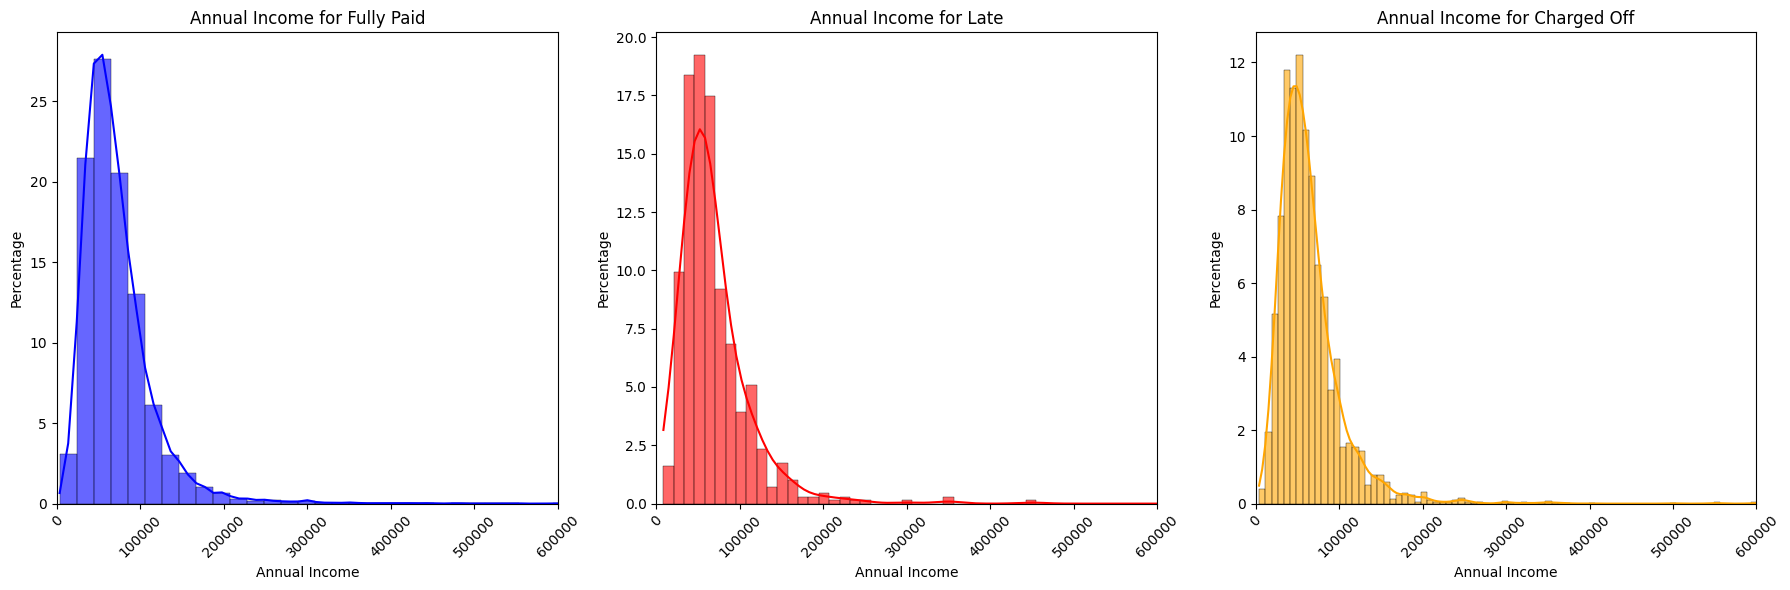

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure and axes for three side-by-side plots without shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the bin size
bin_size = 100

# Histogram for Fully Paid with KDE as percentages
sns.histplot(paid_df['annual_inc'], bins=bin_size, 
             kde=True, ax=axes[0], color='blue', alpha=0.6, stat='percent')
axes[0].set_title('Annual Income for Fully Paid')
axes[0].set_xlabel('Annual Income')
axes[0].set_ylabel('Percentage')
axes[0].set_xlim(0, 600000)  # Set x-axis range
axes[0].tick_params(axis='x', rotation=45)

# Histogram for Late with KDE as percentages
sns.histplot(late_df['annual_inc'], bins=bin_size, 
             kde=True, ax=axes[1], color='red', alpha=0.6, stat='percent')
axes[1].set_title('Annual Income for Late')
axes[1].set_xlabel('Annual Income')
axes[1].set_ylabel('Percentage')  # Give each plot its own y-axis label
axes[1].set_xlim(0, 600000)  # Set x-axis range
axes[1].tick_params(axis='x', rotation=45)

# Histogram for Charged Off with KDE as percentages
sns.histplot(charged_df['annual_inc'], bins=bin_size, 
             kde=True, ax=axes[2], color='orange', alpha=0.6, stat='percent')
axes[2].set_title('Annual Income for Charged Off')
axes[2].set_xlabel('Annual Income')
axes[2].set_ylabel('Percentage')  # Give each plot its own y-axis label
axes[2].set_xlim(0, 600000)  # Set x-axis range
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()
pdf.savefig()
plt.show()


Higher annual incomes are associated with fully paid loans, while lower incomes see increased charge-offs. To mitigate risk, we should consider prioritizing higher-income applicants or implementing stricter criteria for lower-income brackets.

### Loan Amount

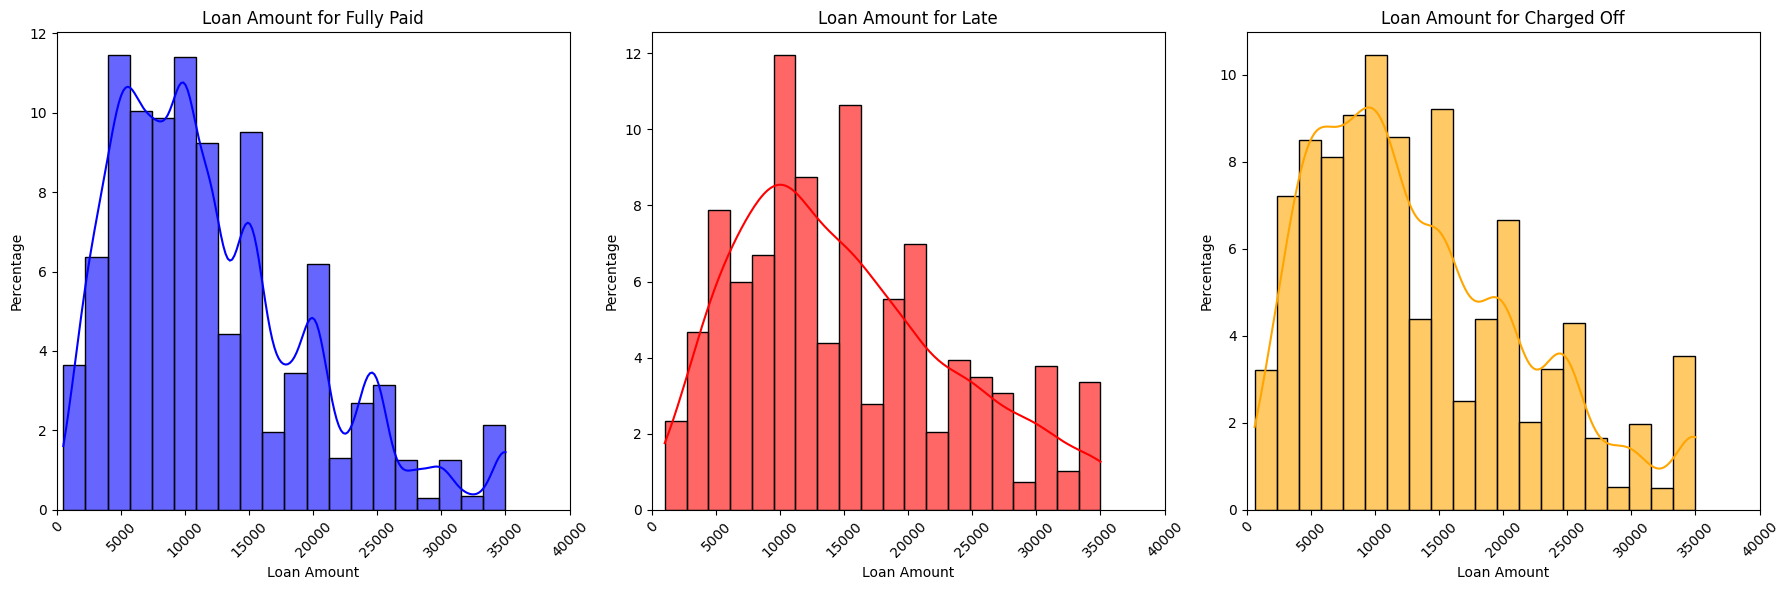

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure and axes for three side-by-side plots without shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the bin size
bin_size = 20  # Adjust the bin size based on the range of loan amounts

# Histogram for Fully Paid with KDE as percentages
sns.histplot(paid_df['loan_amount'], bins=bin_size, 
             kde=True, ax=axes[0], color='blue', alpha=0.6, stat='percent')
axes[0].set_title('Loan Amount for Fully Paid')
axes[0].set_xlabel('Loan Amount')
axes[0].set_ylabel('Percentage')
axes[0].set_xlim(0, 40000)  # Set x-axis range based on your loan amount data
axes[0].tick_params(axis='x', rotation=45)

# Histogram for Late with KDE as percentages
sns.histplot(late_df['loan_amount'], bins=bin_size, 
             kde=True, ax=axes[1], color='red', alpha=0.6, stat='percent')
axes[1].set_title('Loan Amount for Late')
axes[1].set_xlabel('Loan Amount')
axes[1].set_ylabel('Percentage')  # Give each plot its own y-axis label
axes[1].set_xlim(0, 40000)  # Set x-axis range based on your loan amount data
axes[1].tick_params(axis='x', rotation=45)

# Histogram for Charged Off with KDE as percentages
sns.histplot(charged_df['loan_amount'], bins=bin_size, 
             kde=True, ax=axes[2], color='orange', alpha=0.6, stat='percent')
axes[2].set_title('Loan Amount for Charged Off')
axes[2].set_xlabel('Loan Amount')
axes[2].set_ylabel('Percentage')  # Give each plot its own y-axis label
axes[2].set_xlim(0, 40000)  # Set x-axis range based on your loan amount data
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()
pdf.savefig()
plt.show()

Smaller loan amounts tend to be repaid in full more frequently, while larger loans show a higher rate of late payments and charge-offs. A loan cap or adjusted lending criteria for higher loan amounts may help improve repayment rates across the portfolio.

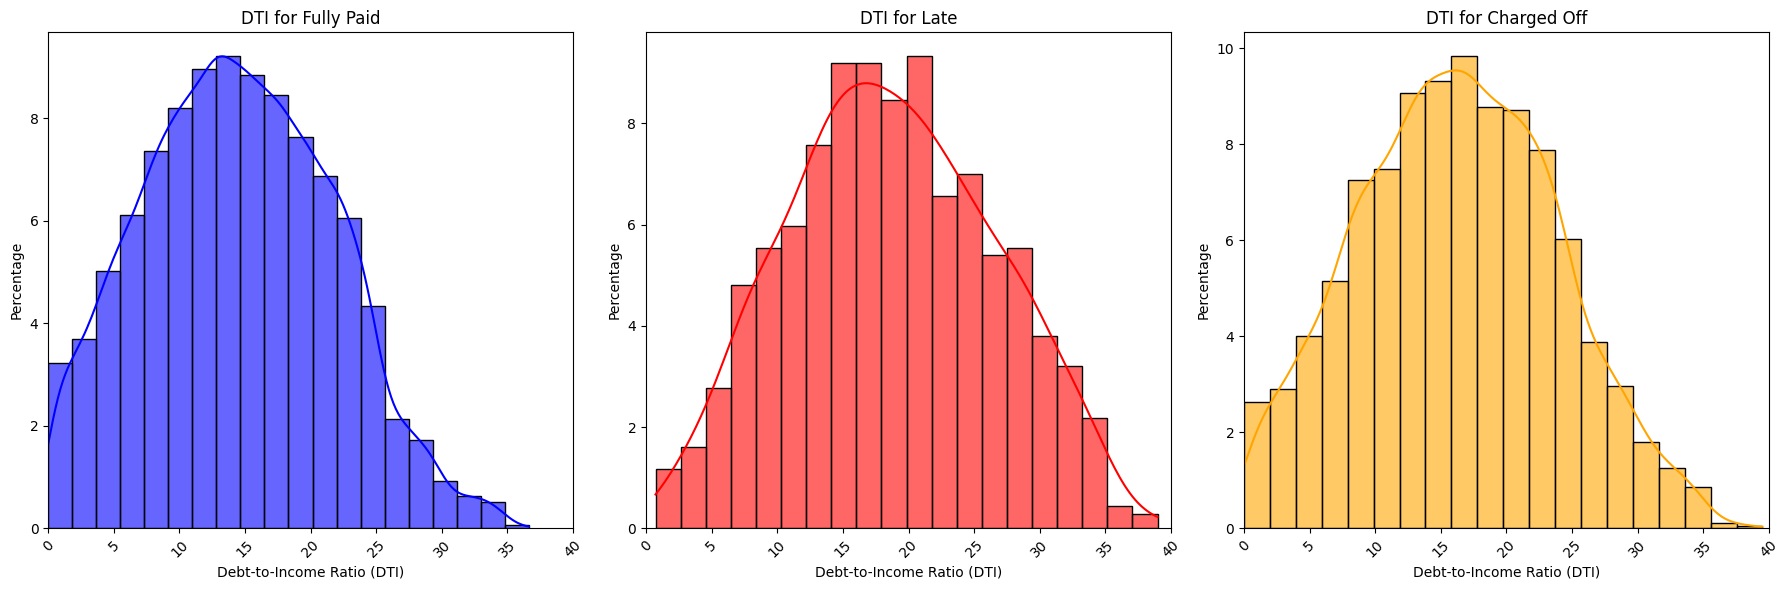

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure and axes for three side-by-side plots without shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the bin size for DTI
bin_size = 20

# Histogram for Fully Paid with KDE as percentages
sns.histplot(paid_df['dti'], bins=bin_size, 
             kde=True, ax=axes[0], color='blue', alpha=0.6, stat='percent')
axes[0].set_title('DTI for Fully Paid')
axes[0].set_xlabel('Debt-to-Income Ratio (DTI)')
axes[0].set_ylabel('Percentage')
axes[0].set_xlim(0, 40)  # Set x-axis range based on typical DTI values
axes[0].tick_params(axis='x', rotation=45)

# Histogram for Late with KDE as percentages
sns.histplot(late_df['dti'], bins=bin_size, 
             kde=True, ax=axes[1], color='red', alpha=0.6, stat='percent')
axes[1].set_title('DTI for Late')
axes[1].set_xlabel('Debt-to-Income Ratio (DTI)')
axes[1].set_ylabel('Percentage')  # Give each plot its own y-axis label
axes[1].set_xlim(0, 40)  # Set x-axis range based on typical DTI values
axes[1].tick_params(axis='x', rotation=45)

# Histogram for Charged Off with KDE as percentages
sns.histplot(charged_df['dti'], bins=bin_size, 
             kde=True, ax=axes[2], color='orange', alpha=0.6, stat='percent')
axes[2].set_title('DTI for Charged Off')
axes[2].set_xlabel('Debt-to-Income Ratio (DTI)')
axes[2].set_ylabel('Percentage')  # Give each plot its own y-axis label
axes[2].set_xlim(0, 40)  # Set x-axis range based on typical DTI values
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()
pdf.savefig()
plt.show()

Lower debt-to-income ratios (DTI) are linked to fully paid loans, while higher DTIs correspond with more defaults. By enforcing stricter DTI limits, we can reduce the risk of late payments and charge-offs.

In [53]:
pdf.close()